# LSTD Learning vs Semi-Gradient Temporal Difference Learning with Linear Function Approximators.

### Authored By: Mithun Vanniasinghe

This notebook will explore the advtanges of LSTD over Semi-gradient Temporal Difference Lerning under linear function approximation. The enviroment that will be used in this example is the 500 state random walk [![random-walk](https://drive.google.com/uc?id=1R3_yD44sL9Q8Lzs2Ekfkk7O5sBoQVQ19)](https://drive.google.com/file/d/1R3_yD44sL9Q8Lzs2Ekfkk7O5sBoQVQ19/view?usp=sharing)



There are 500 states numbered from 1 to 500 and all episodes start with the agent in the centre state. The agent can either take the action of going left or right. An action of left or right will result in an uniform transition to anyone of the 100 left or right neighbouring states.


Arriving in state 0 or state 501 results in termination. Going past the terminal states will also result in termination. For example, if an agent is at state 5 and take the left transition, it has a 96/100 chance of terminating and a 4/100 chance of not terminating.


Terminating in state 501 results in a reward of +1 and terminating in state 0 results in a reward of -1.

## Defining The Enviroment

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Creating the Random Walk Enviroment Class
class RandomWalkEnvironment:
  def env_init(self, env_info={}):
    """
    env_info dict contains:
        {
            num_states: 500 [int],
            start_state: 250 [int],
            left_terminal_state: 0 [int],
            right_terminal_state: 501 [int],
            seed: int
        }
    """
    self.rand_generator = np.random.RandomState(env_info.get("seed")) # set random seed when generating random numbers for reproducibilty
    self.num_states = env_info.get("num_states")
    self.start_state = env_info.get("start_state")
    self.left_terminal_state = env_info.get("left_terminal_state")
    self.right_terminal_state = env_info.get("right_terminal_state")

  def env_start(self):
    """
    Called when the episode starts
    """
    reward = 0
    state = self.start_state
    is_terminal = False
    self.reward_state_tuple = (reward, state, is_terminal)
    return self.reward_state_tuple[1] # return the starting state (250)

  def env_step(self, action):
    """
    Agent moves forward in enviroment given the action the agent just took
    """
    last_state = self.reward_state_tuple[1]
    if action == 0: # agent goes left
      current_state = max(self.left_terminal_state, last_state + self.rand_generator.choice(range(-100,0))) #recall range goes from -100 to -1
      # when agent goes left it can land in any left state but if it goes past the end, it terminates
    else: # action takes right action
      current_state = min(self.right_terminal_state, last_state + self.rand_generator.choice(range(1,101)))

    if current_state == self.left_terminal_state or current_state == self.right_terminal_state:
      is_terminal = True
      if current_state == self.left_terminal_state:
        reward = -1
      else:
        reward = +1
    else:
      is_terminal = False
      reward = 0

    self.reward_state_tuple = (reward, current_state, is_terminal)
    return self.reward_state_tuple





Now lets create our agent class. Let's first create the agent that uses the gradient based methods for TD learning and them the LSTD learning agent. Recall, we are going to construct our feature vectors by doing state aggregation. Suppose states are grouped into groups of 10, this means we will have a 50 dim feature vector. So, before creating our agent class, we can first create a helper function to create this state vector.

In [ ]:
def get_state_feature(num_states_in_group, num_groups, state):
  """
  create a binary encoded vector
  for example, if there are 10 states, 1-10, and num_groups = 5, num_states_in_group is 2, state 6 would be in group 2 (0 indexing)
  its feature vector would look like [0, 0, 1, 0, 0]
  """
  group_idx = (state - 1) // num_states_in_group # subtract 1 to get zero indexing
  return [1 if i == group_idx else 0 for i in range(num_groups)]

class GradientTDAgent:
  def __init__(self):
    self.num_states = None
    self.num_groups = None # this variables specifies how many groups we want for our state aggregation feature vector
    self.step_size = None
    self.discount_factor = None

  def agent_init(self, agent_info={}):
    """
    All info is passed in as a dictionary just like in the enviromet

    """
    self.num_states = agent_info.get("num_states")
    self.num_groups = agent_info.get("num_groups")
    self.step_size = agent_info.get("step_size")
    self.discount_factor = agent_info.get("discount_factor")
    self.num_states_in_group = int(self.num_states / self.num_groups)
    self.rand_generator = np.random.RandomState(agent_info.get("seed"))

    # get feature vectors for all states
    self.all_state_features = np.array([get_state_feature(self.num_states_in_group, self.num_groups, state) for state in range(1, self.num_states + 1)])

    # init all weights to 0, weight vector has same dimension as feature vector (num groups)
    self.weights = np.zeros(self.num_groups)

    self.last_state = None
    self.last_action = None

  def agent_start(self, state):
    """
    Called when env starts
    """

    self.last_state = state
    self.last_action = self.rand_generator.choice([0,1]) # can go either left or right, chooses left (0) or right (1) with equal probabilty => the policy here is uniform
    return self.last_action


  def agent_step(self, reward, state):
    """
    given the current state, the agent updates its paramesters of its value function (weights) and takes a new action
    """
    current_state_feature = self.all_state_features[state-1] # subtract 1 because 0 indexing
    last_state_feature = self.all_state_features[self.last_state-1]

    curr_value_function = self.weights @ current_state_feature # compute dot product between weight and feature vector to get current value function
    prev_value_function = self.weights @ last_state_feature # compute dot product to get previous value function for previous state

    # perform semi-gradient descent update
    self.weights = self.weights + self.step_size*(reward + self.discount_factor * curr_value_function - prev_value_function) * last_state_feature

    # record last state and take a new action
    self.last_state = state
    self.last_action = self.rand_generator.choice([0,1])
    return self.last_action

  def agent_end(self, reward):
    """
    runs when the agent terminates, reward is the reward given for the agent entering the terminal state (+/- 1)

    """
    # there is no feature vector for the terminal states since they are not required to make updates to the value function
    last_state_feature = self.all_state_features[self.last_state -1] # -1 to account for 0 indexing

    #update weights, no need to compute value of current (terminal) state since it has no value => the enviroment has ended
    prev_value_function = self.weights @ last_state_feature # compute dot product to get previous value function for previous state
    self.weights = self.weights + self.step_size*(reward + self.discount_factor * 0 - prev_value_function) * last_state_feature
    return # return no new action because agent has reached a terminal state

  def return_state_values(self):
    """
    When called this method will return the current estimated state values for all states
    """
    state_values = self.all_state_features @ self.weights # performing a matrix vector product, each feature vector for each state is taking a dot product with the weight vector
    return state_values # we return the resulting array of scalar values

To test how well we are learning, we want to compute the average Value Error. Here we will calculate sqaure root of the Value Error. In the folder with this notebook contains the state distbution, μ(s) , as well as the true state value $v_π(s)$, which was computed via dynamic programming and knowledge of the enviroment dynamics.

[![value_error](https://drive.google.com/uc?id=1hkGWkWNAVlLAxdCH1UNGE7Yo1d2Cy3KE)](https://drive.google.com/file/d/1hkGWkWNAVlLAxdCH1UNGE7Yo1d2Cy3KE/view?usp=sharing)

In [ ]:

def calc_RMSVE(learned_state_val):
  true_state_val = np.load('/content/true_V.npy')
  state_distribution = np.load('/content/state_distribution.npy')
  MSVE = np.sum(np.multiply(state_distribution, np.square(true_state_val - learned_state_val)))
  RMSVE = np.sqrt(MSVE)
  return RMSVE

## Run The Experiment

Now we are ready to run the experiment. Let's use 10 state aggregation, meaning we group states into groups of 10

In [ ]:
# define function to run experiment

def run_experiment(enviroment, agent, enviroment_param, agent_param, experiment_param):
  # create an array to hold all the value errors
  # +1 to account for recording at begining
  # experiment_parameters["episode_eval_frequency"]:  after how many training episodes an evaluation episode will be conducted, assume it will be 1
  agent_rmsve = np.zeros(int(experiment_param["num_episodes"]/experiment_param["episode_eval_frequency"]) + 1)
  lstd_agent_rmsve = np.zeros(int(experiment_param["num_episodes"]/experiment_param["episode_eval_frequency"]) + 1)

  # save learned state value at end of episode:
  agent_state_val = np.zeros(enviroment_param["num_states"])
  lsted_agent_state_val = np.zeros(enviroment_param["num_states"])

  #init agent and enviromet
  for run in tqdm(range(1, experiment_param["num_runs"] + 1)): # average over multiple runs
    env = enviroment
    env.env_init(env_info=enviroment_param)
    agent = agent
    agent.agent_init(agent_info=agent_param)
    total_reward = 0.0
    num_steps = 0
    num_episodes = 0

    current_value_function = agent.return_state_values()
    agent_rmsve[0] += calc_RMSVE(current_value_function)

    for episode in range(1, experiment_param["num_episodes"] + 1):
      is_terminal = False
      last_state = env.env_start()
      last_action = agent.agent_start(last_state)
      observation = (last_state, last_action)
      while is_terminal == False:
        (reward, last_state, term) = env.env_step(last_action)
        total_reward += reward
        if term:
            num_episodes += 1
            agent.agent_end(reward)
            roat = (reward, last_state, None, term)
        else:
            num_steps += 1
            last_action = agent.agent_step(reward, last_state)
            roat = (reward, last_state, last_action, term)

        step_result = roat
        is_terminal = step_result[3]


      if episode % experiment_param["episode_eval_frequency"] == 0:
        current_value_function = agent.return_state_values()
        agent_rmsve[int(episode/experiment_param["episode_eval_frequency"])] += calc_RMSVE(current_value_function)


    if run == experiment_param["num_runs"]: # if this is the last run, save the state values
      agent_state_val = agent.return_state_values()


    agent_rmsve /= experiment_param["num_runs"] # average of number of runs



  return agent_state_val, agent_rmsve







## Run Experiment with Gradient Agent

In [ ]:
experiment_parameters = {
"num_runs" : 50,
"num_episodes" : 2000,
"episode_eval_frequency" : 1 # evaluate every 10 episodes
}
# Environment parameters
environment_parameters = {
    "num_states" : 500,
    "start_state" : 250,
    "left_terminal_state" : 0,
    "right_terminal_state" : 501,
    "seed": 1
}
# Agent parameters
agent_parameters = {
    "num_states": 500,
    "num_groups": 10,
    "step_size": 0.01,
    "discount_factor": 0.9,
    "seed": 1,
}
current_env = RandomWalkEnvironment()
current_agent = GradientTDAgent()

agent_state_val, agent_rmsve = run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)

100%|██████████| 50/50 [02:42<00:00,  3.24s/it]


In [ ]:
len(agent_rmsve)

2001

Text(0.5, 0, 'Episodes')

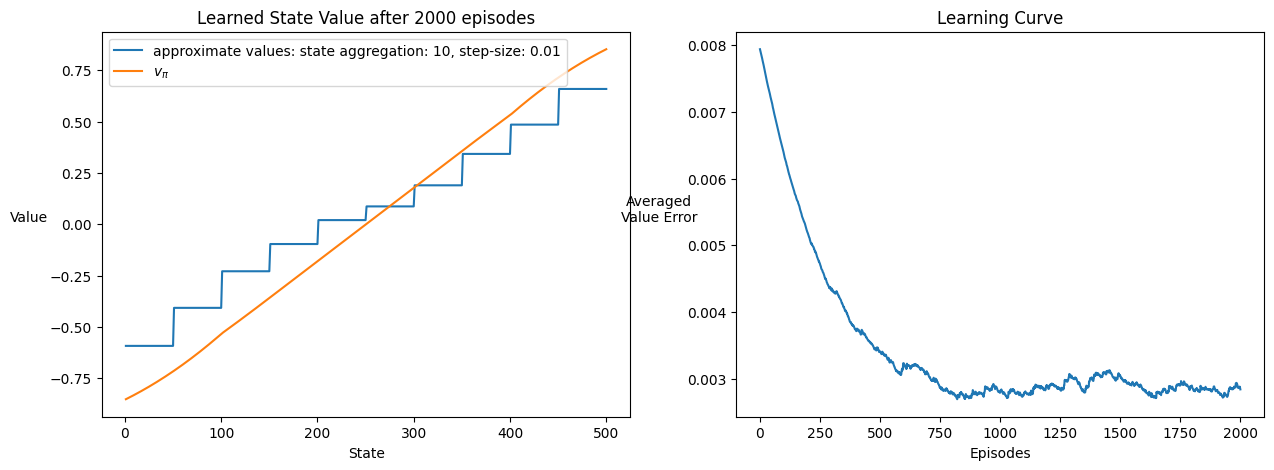

In [ ]:
true_state_val = np.load('/content/true_V.npy')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt1_x_legend = range(1,len(agent_state_val[:]) + 1) # capture all states
graph_current_agent_V, = ax[0].plot(plt1_x_legend, agent_state_val[:], label="approximate values: state aggregation: {}, step-size: {}".format(agent_parameters["num_groups"], agent_parameters["step_size"]))
graph_true_V, = ax[0].plot(plt1_x_legend, true_state_val[:], label="$v_\pi$")
ax[0].set_title("Learned State Value after 2000 episodes")
ax[0].set_xlabel('State')
ax[0].set_ylabel('Value', rotation=0, labelpad=15)
ax[0].legend(handles=[graph_current_agent_V, graph_true_V])

plt2_x_legend = range(1,len(agent_rmsve[:]) + 1)
graph_current_agent_RMSVE, = ax[1].plot(plt2_x_legend, agent_rmsve[:])
ax[1].set_ylabel('Averaged\nValue Error', rotation=0, labelpad=20)
ax[1].set_title("Learning Curve")
ax[1].set_xlabel('Episodes')

Now lets create our LSTD agent. The only method that we will have to change to our Gradient agent class is how the updates are done.

In [ ]:
class LSTDAgent(GradientTDAgent):
  def agent_init(self, agent_info={}):
    """
    All info is passed in as a dictionary just like in the enviromet

    """
    self.num_states = agent_info.get("num_states")
    self.num_groups = agent_info.get("num_groups")
    self.epsilon = agent_info.get("epsilon")
    self.discount_factor = agent_info.get("discount_factor")
    self.num_states_in_group = int(self.num_states / self.num_groups)
    self.rand_generator = np.random.RandomState(agent_info.get("seed"))

    # get feature vectors for all states
    self.all_state_features = np.array([get_state_feature(self.num_states_in_group, self.num_groups, state) for state in range(1, self.num_states + 1)])

    # init all weights to 0, weight vector has same dimension as feature vector (num groups)
    self.weights = np.zeros(self.num_groups)

    self.last_state = None
    self.last_action = None

    # init A_inverse matrix and b vector
    self.A = (self.epsilon) * np.eye(self.num_groups)
    self.b = np.zeros(self.num_groups)

  def agent_start(self, state):
    """
    Called when env starts
    """

    self.last_state = state
    self.last_action = self.rand_generator.choice([0,1]) # can go either left or right, chooses left (0) or right (1) with equal probabilty => the policy here is uniform
    return self.last_action

  def agent_step(self, reward, state):
    """
    given the current state, the agent updates its paramesters of its value function (weights) and takes a new action
    """
    current_state_feature = self.all_state_features[state-1] # subtract 1 because 0 indexing
    last_state_feature = self.all_state_features[self.last_state-1]

    self.A += np.outer(last_state_feature, (last_state_feature - self.discount_factor*current_state_feature)) # outer product
    self.b += reward*last_state_feature


    # record last state and take a new action
    self.last_state = state
    self.last_action = self.rand_generator.choice([0,1])
    return self.last_action

  def agent_end(self, reward):
    """
    runs when the agent terminates, reward is the reward given for the agent entering the terminal state (+/- 1)

    """
    # there is no feature vector for the terminal states since they are not required to make updates to the value function
    last_state_feature = self.all_state_features[self.last_state -1] # -1 to account for 0 indexing


    self.A += np.outer(last_state_feature, last_state_feature) # outer product
    self.b += reward*last_state_feature


  def return_state_values(self):
    """
    When called this method will return the current estimated state values for all states
    """
    self.weights = np.linalg.inv(self.A) @ self.b # compute weights
    # print("A, b: ", self.A, self.b)
    # print("weights: ", self.weights)
    state_values = self.all_state_features @ self.weights # performing a matrix vector product, each feature vector for each state is taking a dot product with the weight vector
    return state_values # we return the resulting array of scalar values

## Run Experiment with LSTD Agent


In [ ]:
experiment_parameters = {
"num_runs" : 50,
"num_episodes" : 2000,
"episode_eval_frequency" : 1 # evaluate every 10 episodes
}
# Environment parameters
environment_parameters = {
    "num_states" : 500,
    "start_state" : 250,
    "left_terminal_state" : 0,
    "right_terminal_state" : 501,
    "seed": 1
}
# Agent parameters
agent_parameters = {
    "num_states": 500,
    "num_groups": 10,
    "epsilon": 0.0001,
    "step_size":  0.01,
    "discount_factor": 0.9,
    "seed": 1,
}
current_env = RandomWalkEnvironment()
current_agent = LSTDAgent()
# current_agent = GradientTDAgent()

lstd_agent_state_val, lstd_agent_rmsve = run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)

100%|██████████| 50/50 [05:06<00:00,  6.12s/it]


<ipython-input-164-09908fc5807b>:10: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7d7efa737370> starts with '_'. It is thus excluded from the legend.
  ax[0].legend(handles=[graph_current_agent_V, graph_true_V])


Text(0.5, 0, 'Episodes')

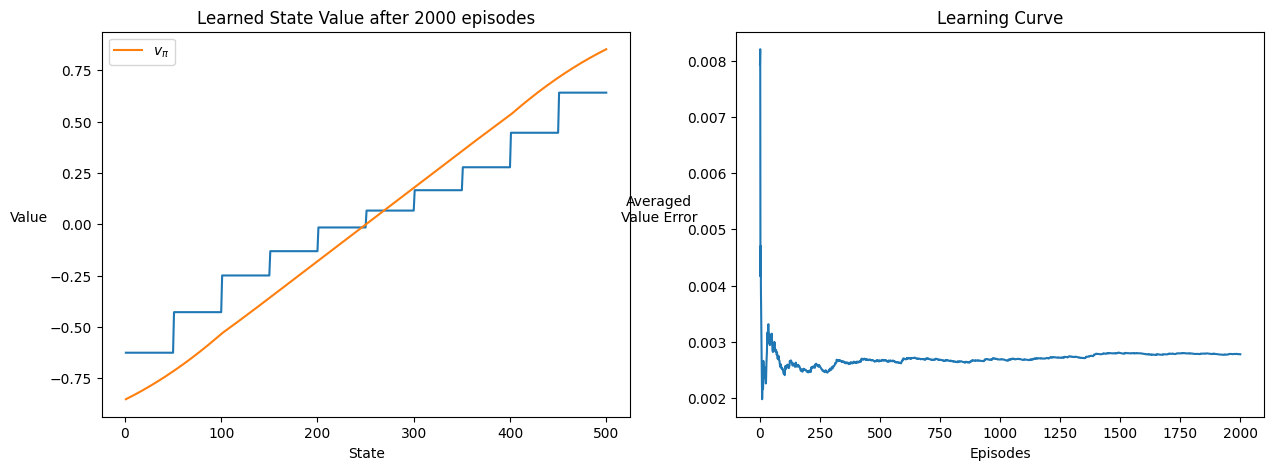

In [ ]:
true_state_val = np.load('/content/true_V.npy')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt1_x_legend = range(1,len(lstd_agent_state_val[:]) + 1) # capture all states
graph_current_agent_V, = ax[0].plot(plt1_x_legend, lstd_agent_state_val[:])
graph_true_V, = ax[0].plot(plt1_x_legend, true_state_val[:], label="$v_\pi$")
ax[0].set_title("Learned State Value after 2000 episodes")
ax[0].set_xlabel('State')
ax[0].set_ylabel('Value', rotation=0, labelpad=15)
ax[0].legend(handles=[graph_current_agent_V, graph_true_V])

plt2_x_legend = range(1,len(lstd_agent_rmsve[:]) + 1)
graph_current_agent_RMSVE, = ax[1].plot(plt2_x_legend, lstd_agent_rmsve[:])
ax[1].set_ylabel('Averaged\nValue Error', rotation=0, labelpad=20)
ax[1].set_title("Learning Curve")
ax[1].set_xlabel('Episodes')

# Conclusions

As can be seen from comparing the learning curves of the Gradient Agent vs the LSTD Agent, the LSTD agent had a much smoother convergence and learned much faster too! This is because it uses all of its past experience to perform updates to the weights and computes the TD fixed point exactly. Thus, LSTD is a crucial RL algorithm to have in your tool kit esspetially when you want to learn quickly and are limited in data.

## References:

Bradtke, S. J., & Barto, A. G. (1996). Linear least-squares algorithms for temporal difference learning. Machine Learning, 22(1), 33–57. https://doi.org/10.1007/BF00114723

Boyan, J. A. (1999). Least-squares temporal difference learning. Proceedings of the Sixteenth International Conference on Machine Learning. http://incompleteideas.net/papers/boyanLSTDlambda.pdf

Sutton, R. S., & Barto, A. G. (2018). Reinforcement Learning: An Introduction (2nd ed.). MIT Press.
University of Alberta. (n.d.). Reinforcement Learning Specialization [Specialization]. Coursera. https://www.coursera.org/specializations/reinforcement-learning/